In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from collections import namedtuple
from datetime import date, timedelta


sns.set_style("darkgrid")

In [2]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"

interval_map = {
    "1m": timedelta(minutes=360),
    "1h": timedelta(hours=24*30),
    "1d": timedelta(days=365),   
}


start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")

start_date, end_date

('2022-09-28', '2022-10-28')

In [21]:
# ticker1 = "GLD"
# ticker2 = "GDX"

# ticker1 = "IVW"
# ticker2 = "SPY"

# ticker1 = "NG=F"
# ticker2 = "BZ=F"

ticker1 = "BZ=F"
ticker2 = "CL=F"

# ticker1 = "BNO"
# ticker2 = "USO"

df1 = yf.download(ticker1, start=start_date, end=end_date, interval=interval)
df2 = yf.download(ticker2, start=start_date, end=end_date, interval=interval)

# Use common index to align dates.
df = pd.DataFrame(index=df1.index)


colname = "Adj Close"
df["S1"] = df1[colname]
df["S2"] = df2[colname]

df.index = pd.to_datetime(df.index)

# Drop missing entries
df.dropna(inplace=True)

df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,S1,S2
2022-10-27 13:00:00-04:00,96.849998,89.080002
2022-10-27 14:00:00-04:00,96.730003,88.790001
2022-10-27 15:00:00-04:00,97.019997,89.029999
2022-10-27 16:00:00-04:00,96.610001,88.599998
2022-10-27 18:00:00-04:00,96.589996,88.589996


Let: 

    alpha := proportion of asset 1 (S1)
    beta  := proportion of asset 2 (S2)
    
    A := amount (e.g. $) to long asset 1 (S1)
    B := amount (e.g. $) to short asset 2 (S2)

alpha = A / S1_0.
beta  = B / S2_0.

Where: Si_0 := value of asset i, Si, @ time t=0.

WLOG: A = 1. --> alpha = 1 / S1_0.  

Now choose beta:  

V1: arbitrarily choose B = 0.1 (for no particular reason).

In [22]:
# (float, float, float, tuple)
OUParams = namedtuple("ou_params", "theta mu sigma sigma_sq sums")


def calc_optimal_ou_params(x, dt):
    n = x.shape[0]
    
    # 1. Define sums - all sums are from i=1:n

    # x_{i-1} --> from 0:n-1 --> sum all but last value.
    X_x = np.sum(x[:-1])

    # x_{i} --> from 1:n --> sum all but 0th value.
    X_y = np.sum(x[1:])

    # (x_{i-1})^2
    X_xx = np.sum(x[:-1]**2)

    # (x_{i})^2
    X_yy = np.sum(x[1:]**2)

    # x_{i-1} * x_{i}
    X_xy = np.sum(x[:-1]*x[1:])

    
    # 2. Optimal OU Parameters, given (alpha, beta). Explicit solution to MLE.
    
    # Long-run mean: theta
    theta = (X_y*X_xx - X_x*X_xy) / (n*(X_xx - X_xy) - (X_x**2 - X_x*X_y))
    
    # Speed of mean reversion: mu
    phi = (X_xy - theta*(X_x + X_y) + n*(theta**2)) / (X_xx - 2*theta*X_x + n*(theta**2))
    mu = -np.log(phi) / dt
    
    assert phi < 1.0, "Plot ln(x), e.g. Wolfram."
    assert mu > 0.0, "Speed of MR must be postive."
    
    # Volatility parameter: sigma. Cleaner to find sigma_sq first, then take sqrt.
    a = n*(1.0 - np.exp(-2.0*mu*dt))
    b = X_yy - 2.0*np.exp(-mu*dt)*X_xy + np.exp(-2.0*mu*dt)*X_xx - 2.0*theta*(1.0 - np.exp(-mu*dt))*(X_y - np.exp(-mu*dt)*X_x) + n*(theta**2)*( (1 - np.exp(-mu*dt))**2 )

    sigma_sq = 2*mu*b/a
    assert sigma_sq > 0.0, "Vol_sq of MR must be postive."
    
    sigma = np.sqrt(sigma_sq)
    
    return OUParams(theta, mu, sigma, sigma_sq, (X_x, X_y, X_xx, X_yy, X_xy))


def log_likelihood_ou(theta, mu, sigma_sq, x, dt):
    n = x.shape[0]
    
    # tau := sigma_tilde in the paper.
    tau_sq = sigma_sq*(1 - np.exp(-2.0*mu*dt))/(2.0*mu)
    tau = np.sqrt(tau_sq)

    c = 1/(2.0*n*tau_sq)
    
    sq_sum = np.sum([(x[i] - x[i-1]*np.exp(-mu*dt) - theta*(1 - np.exp(-mu*dt)))**2 for i in range(1,n)])
    log_likelihood = -0.5*np.log(2.0*math.pi) - np.log(tau) - c * sq_sum
    
    return log_likelihood

Text(0, 0.5, 'Log-Likelihood')

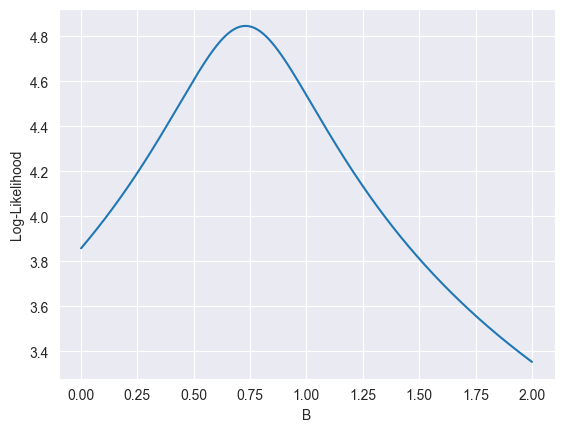

In [23]:
# V1: brute force search over B. Do this until scale causes speed to be an issue.
A = 1.0

start = 0.001
end = 2.0
num = int(1/start)


B_candidates = np.linspace(start, end, num)

alpha = A / df["S1"].iloc[0]

# TODO: check this!  Might have to change dW inside OUModel - e.g. dW^2.
dt = 1
# dt = 60

mus = []
log_likelihoods = []
for B in B_candidates:
    beta = B / df["S2"].iloc[0]

    # Define:  X_t = alpha * S1_t - beta * S2_t
    x = (alpha*df["S1"] - beta*df["S2"]).to_numpy()

    ou = calc_optimal_ou_params(x, dt)
    ll = log_likelihood_ou(theta=ou.theta, mu=ou.mu, sigma_sq=ou.sigma_sq, x=x, dt=dt)

    log_likelihoods.append(ll)
    mus.append(ou.mu)
    
    
plt.plot(B_candidates, log_likelihoods)
plt.xlabel("B")
plt.ylabel("Log-Likelihood")

In [24]:
i = np.argmax(log_likelihoods)
B_candidates[i], log_likelihoods[i], mus[i]

(0.7293643643643644, 4.846262788032056, 0.004337200678376092)

In [25]:
j = np.argmax(mus)
B_candidates[j], log_likelihoods[j], mus[j]

(1.0355175175175173, 4.477651611184008, 0.014522335732091966)

In [26]:
# To avoid having to store all of the OU Parameters for every candidate of B, re-run the optimal run to recover the OU Parameters.
alpha = A / df["S1"].iloc[0]
beta = B_candidates[i] / df["S2"].iloc[0]
x = (alpha*df["S1"] - beta*df["S2"]).to_numpy()

ou_params = calc_optimal_ou_params(x, dt)
ll = log_likelihood_ou(theta=ou_params.theta, mu=ou_params.mu, sigma_sq=ou_params.sigma_sq, x=x, dt=dt)

# Check nothing changed in the re-run
assert ll == log_likelihoods[i]

In [27]:
# Test the process by running through an OU Model

from algo.sde.ornstein_uhlenbeck import OrnsteinUhlenbeck

In [28]:
# TODO: update the signature of OU s.t. k becomes mu
ou_model = OrnsteinUhlenbeck(theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
ou_process_simulated = ou_model(num_samples=len(x))

ou_params_sim = calc_optimal_ou_params(ou_process_simulated, dt)
ll_sim = log_likelihood_ou(theta=ou_params_sim.theta, mu=ou_params_sim.mu, sigma_sq=ou_params_sim.sigma_sq, x=ou_process_simulated, dt=dt)

In [29]:
# Want these differences to be as small as possible
print(f"pc diff theta = {100*(ou_params.theta - ou_params_sim.theta) / ou_params.theta:.3f}%")
print(f"pc diff mu    = {100*(ou_params.mu - ou_params_sim.mu) / ou_params.mu:.3f}%")
print(f"pc diff sigma = {100*(ou_params.sigma - ou_params_sim.sigma) / ou_params.sigma:.3f}%")
print(f"pc diff ll    = {100*(ll - ll_sim) / ll:.3f}%")

pc diff theta = 5.008%
pc diff mu    = 5.333%
pc diff sigma = 5.073%
pc diff ll    = -1.071%
